In [12]:
%matplotlib ipympl
from matplotlib import colormaps
import matplotlib.pyplot as plt
import numpy as np
from functools import partial
from onix.data_tools import get_experiment_data
from onix.analysis.fitter import Fitter
from onix.analysis.helper import group_and_average_data
from tqdm import tqdm
import pprint
import pint
from onix.analysis.functions.optical_antihole_check import *

# PLOTTING OPTICAL SPECTRUM
### plot_antihole_data(data_numbers, normalize=True, fitit=False, errors=True, labels=None)
    - data number input: data_numbers as int, tuple, or list 
    - normalize: normalizes to monitors PD
    - fitit: fit to gaussian and plot fit
    - errors: include errorbars ------------> CHECK it seems too small
    - labels: select which labels to plot, e.g. labels=["rf"] only plots only rf labelled data
                   if labels is None: plots all data

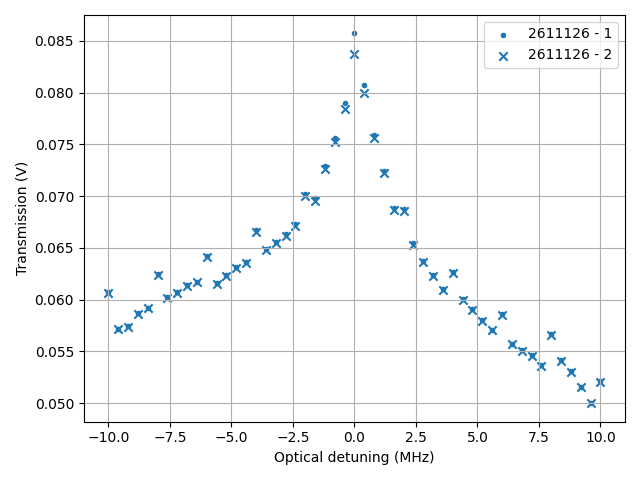

In [2]:
plot_antihole_data(2611126, normalize=False, fitit=False, errors=False, labels=None)

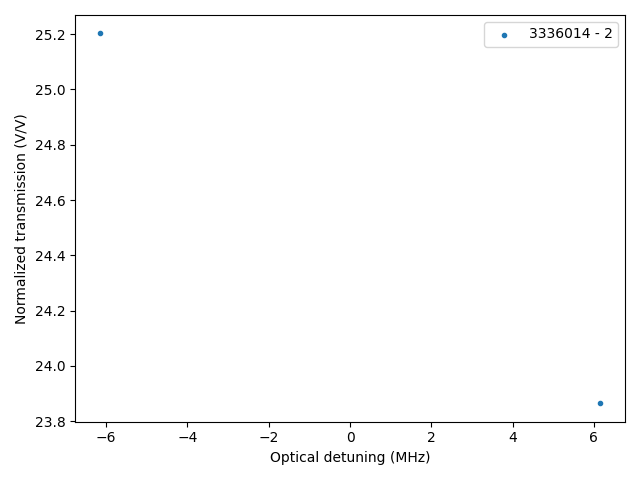

In [86]:
plot_antihole_data(3336014)

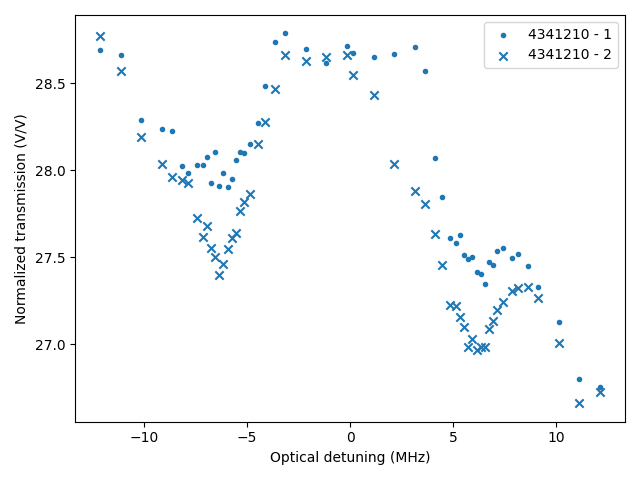

In [189]:
plot_antihole_data(4341210)

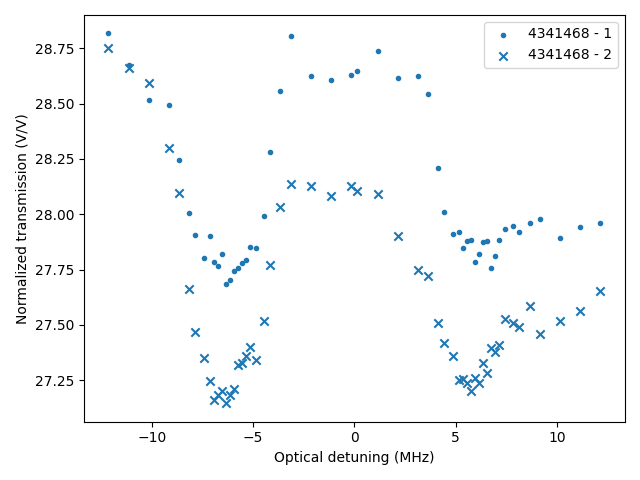

In [195]:
plot_antihole_data(4341468)

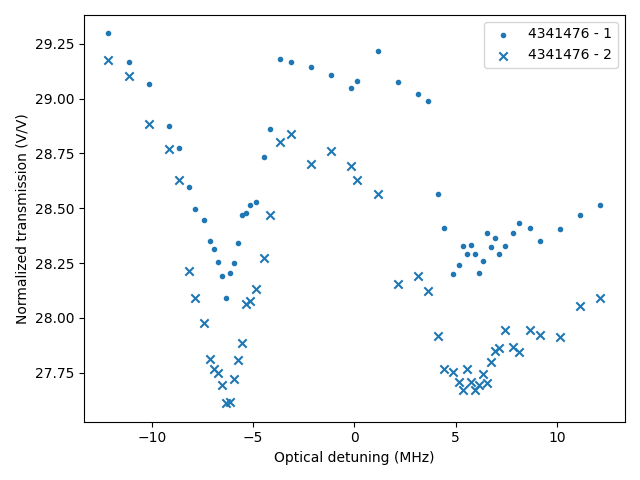

In [196]:
plot_antihole_data(4341476)

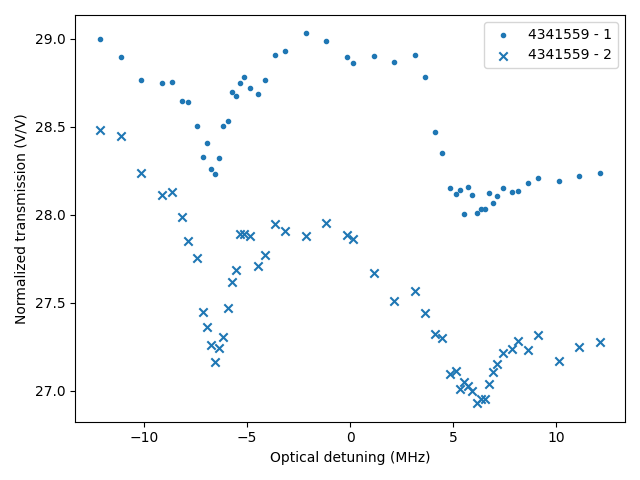

In [198]:
plot_antihole_data(4341559)

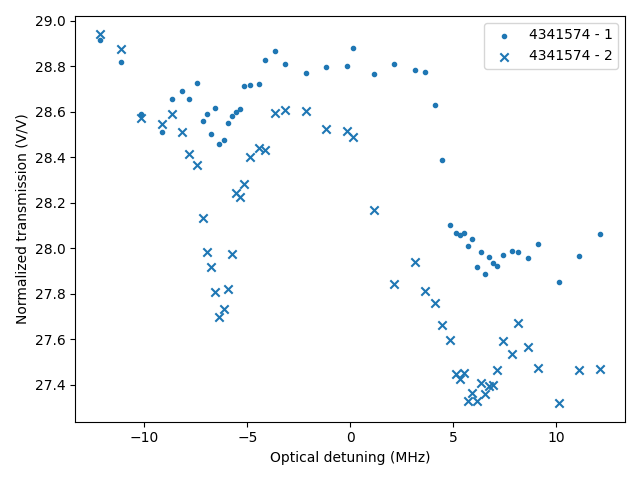

In [199]:
plot_antihole_data(4341574)

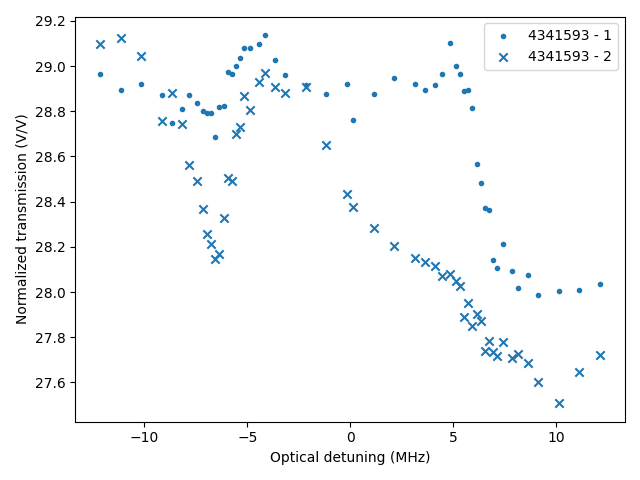

In [200]:
plot_antihole_data(4341593)

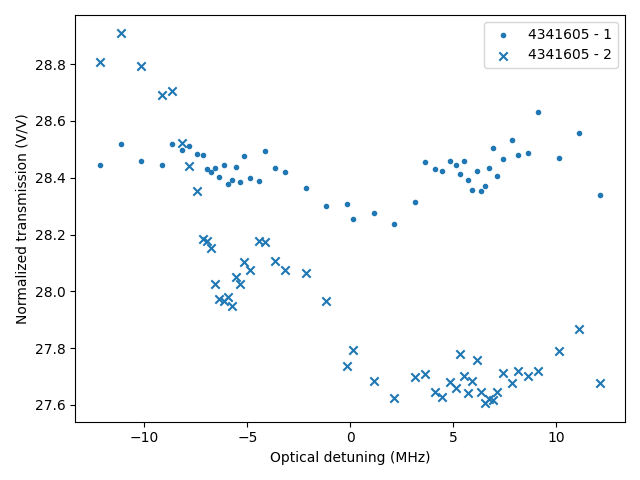

In [201]:
plot_antihole_data(4341605)

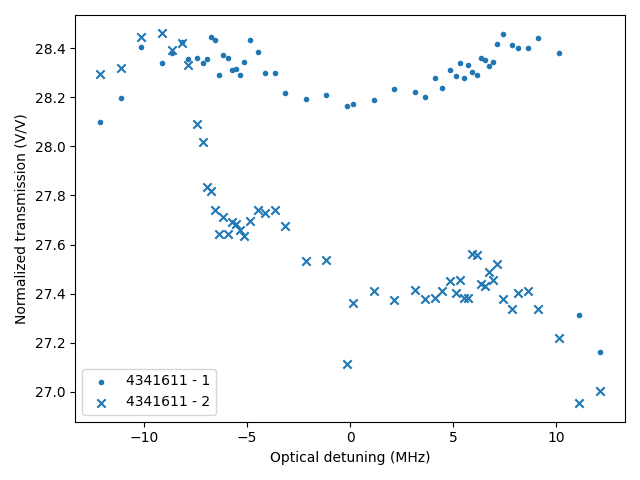

In [203]:
plot_antihole_data(4341611)

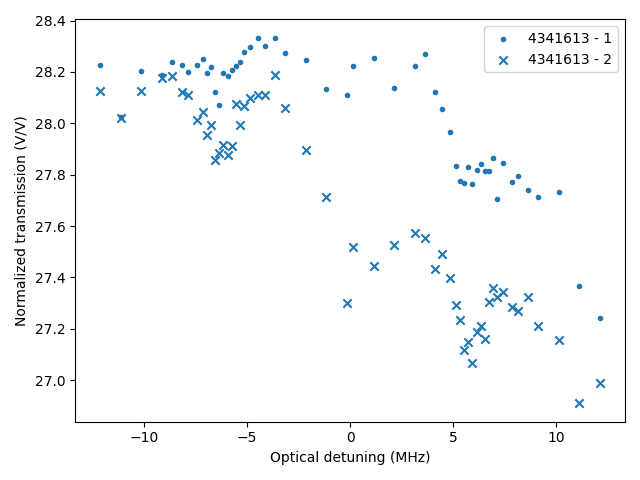

In [204]:
plot_antihole_data(4341613)

In [235]:
d,h = get_experiment_data(4337260)
h["params"]["detect"]

{'transition': 'ac',
 'detunings': array([ 0. ,  0.1, -0.1,  0.2, -0.2,  0.4, -0.4,  0.7, -0.7,  1. , -1. ,
         2. , -2. ]) <Unit('megahertz')>,
 'on_time': 100 <Unit('microsecond')>,
 'off_time': 2 <Unit('microsecond')>,
 'delay': 8 <Unit('microsecond')>,
 'ao_amplitude': 200,
 'simultaneous': False,
 'cycles': {'1': 32, '2': 32},
 'name': 'digitizer',
 'randomize': False}

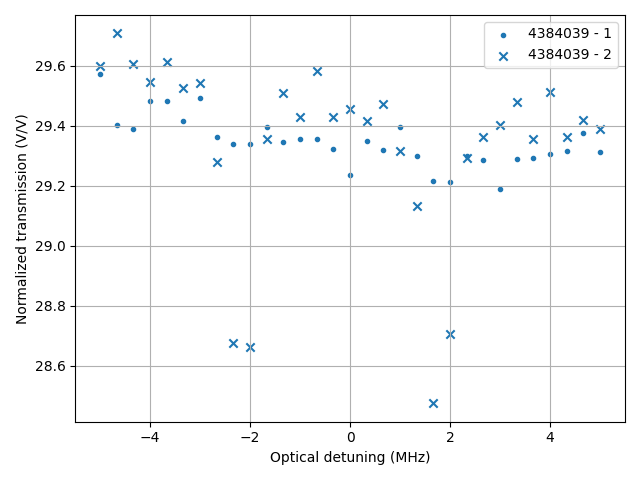

In [43]:
plot_antihole_data(4384039)

In [435]:
get_experiment_data(4382470)[0]["monitors_avg"][0]

array([0.00802053, 0.00879004, 0.0092219 , 0.00906333, 0.00831913,
       0.00916263, 0.00866797, 0.00891908, 0.00829931, 0.00844258,
       0.00900365, 0.00923346, 0.00912725, 0.0091436 , 0.00928618,
       0.00900455, 0.00804388, 0.0092101 , 0.00899935, 0.00809285,
       0.00930817, 0.00803328, 0.00915017, 0.00917981, 0.00896537,
       0.00925909, 0.00883322, 0.00940363, 0.00845912, 0.00895182])

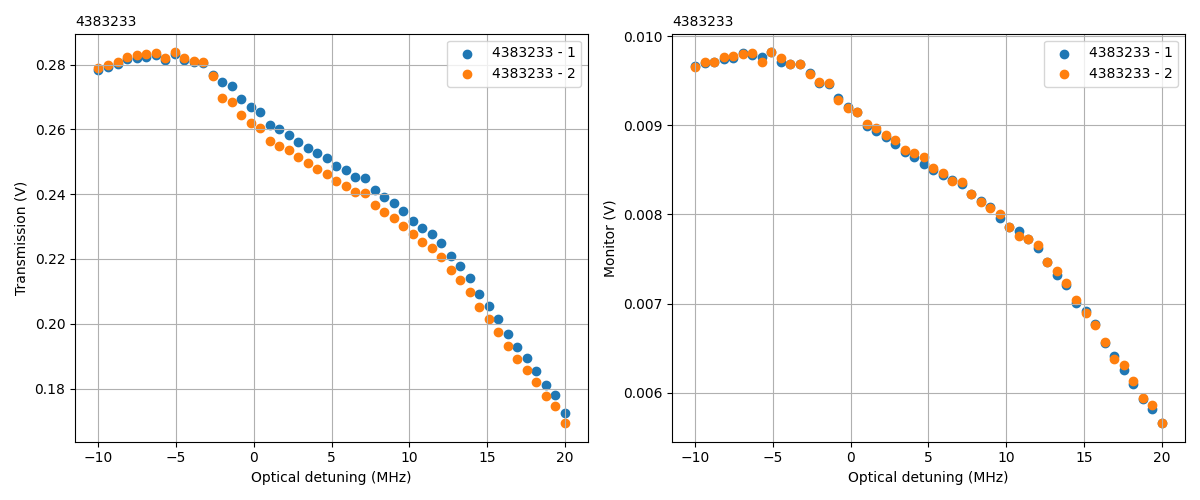

In [41]:
plot_raw_data(4383233)

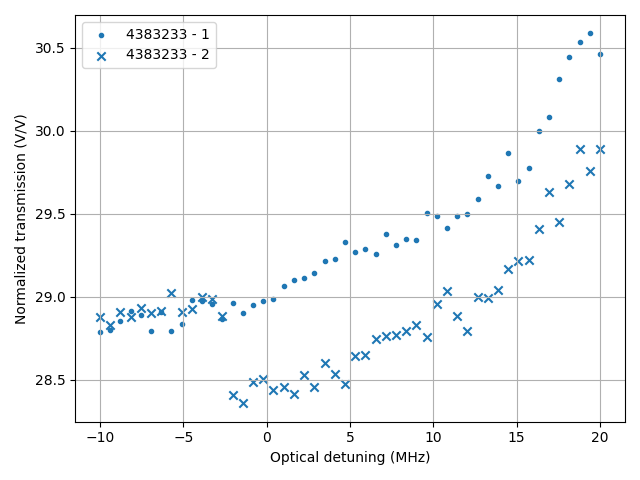

In [42]:
plot_antihole_data(4383233)

In [45]:
d, h = get_experiment_data(4383233)
h["params"]["chasm"]

{'scan': 10 <Unit('megahertz')>,
 'durations': 10 <Unit('millisecond')>,
 'ao_amplitude': 2000,
 'transitions': ['bb'],
 'repeats': 20,
 'detunings': 0 <Unit('megahertz')>}

/tmp/ipykernel_2092513/799552915.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


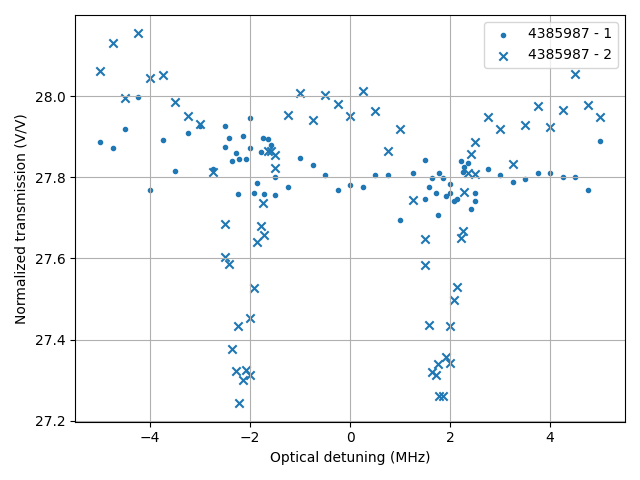

In [40]:
plot_antihole_data(4385987)

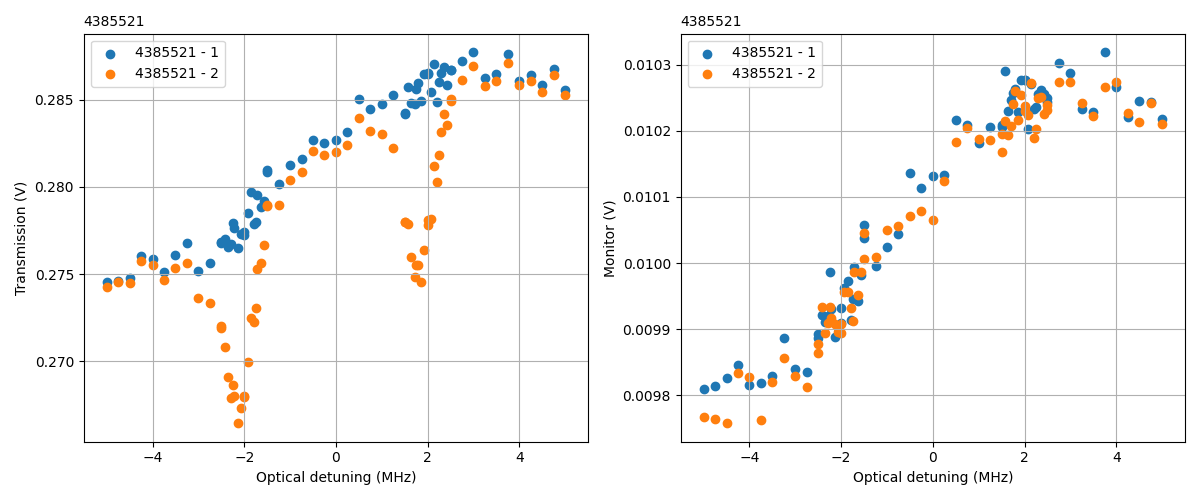

In [39]:
plot_raw_data(4385521)

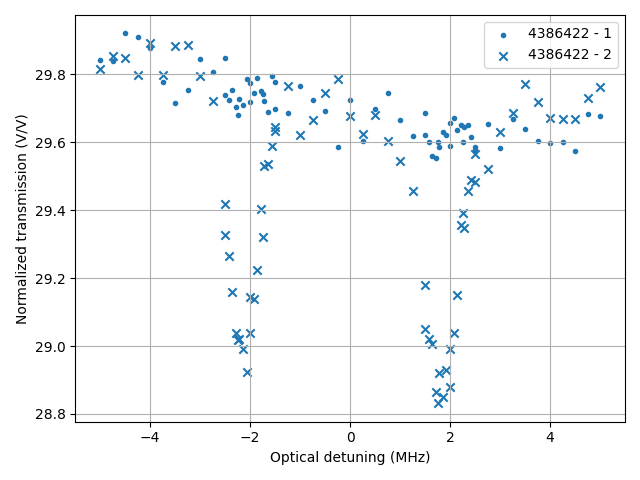

In [38]:
plot_antihole_data(4386422)

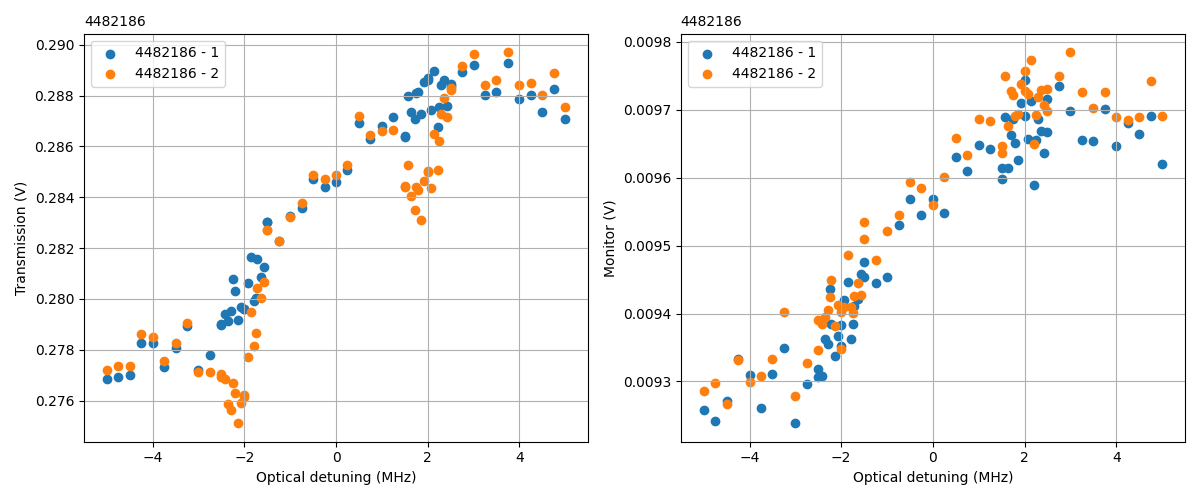

In [9]:
plot_raw_data(4482186)

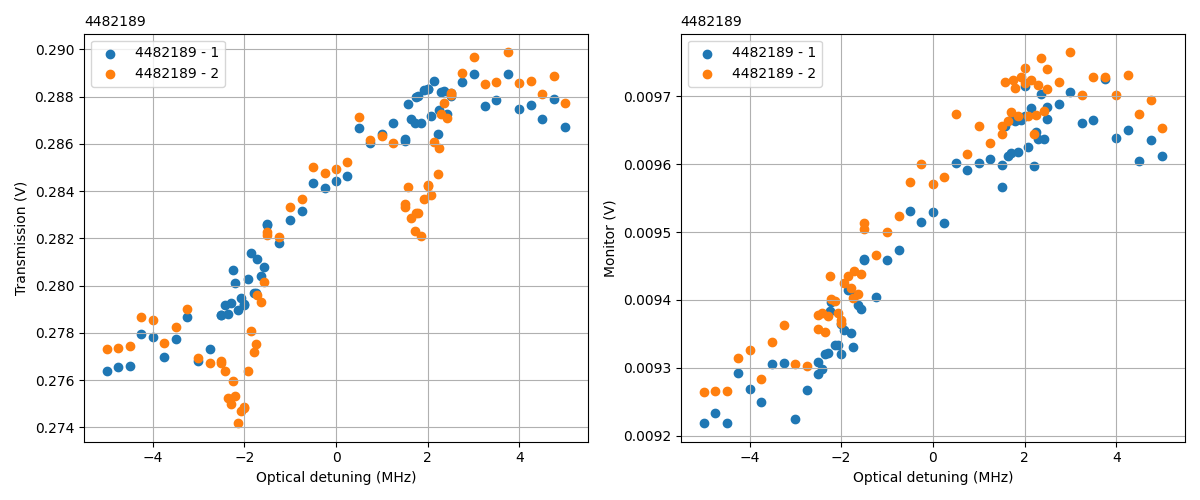

In [10]:
plot_raw_data(4482189)

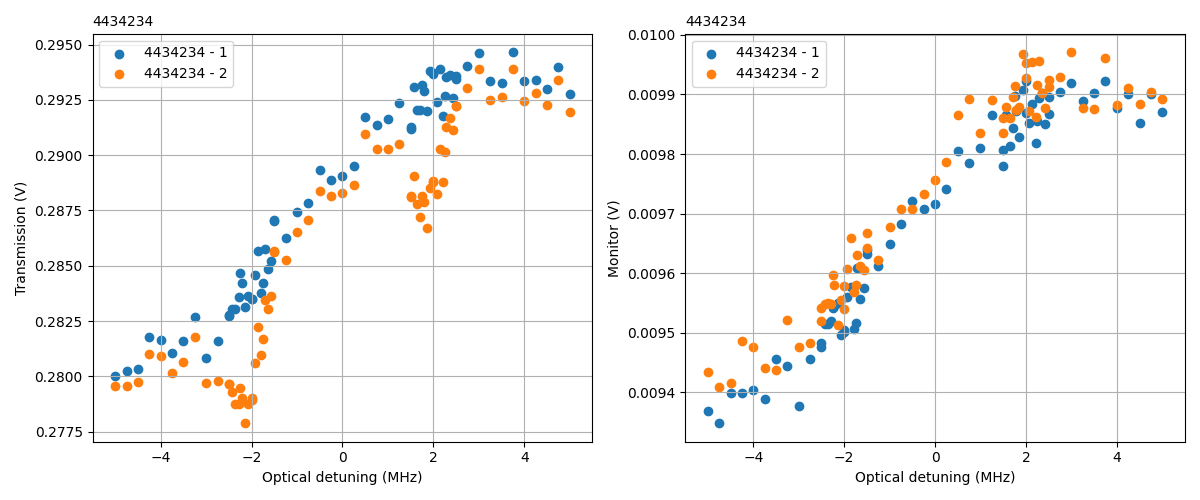

In [33]:
plot_raw_data((4482189 + 4386279) // 2 + 0)

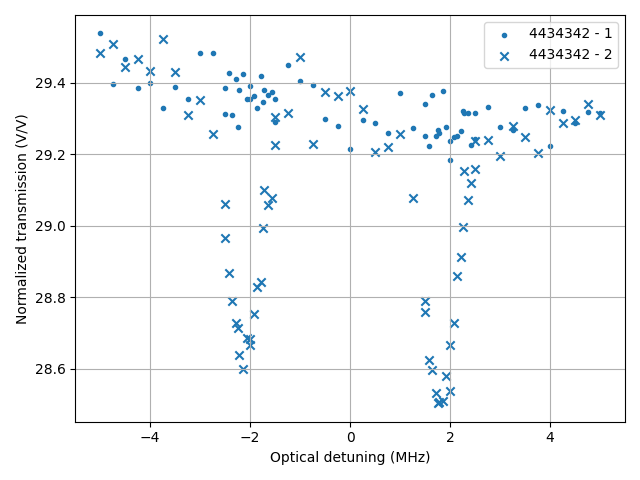

In [37]:
plot_antihole_data((4482189 + 4386279) // 2 + 108)

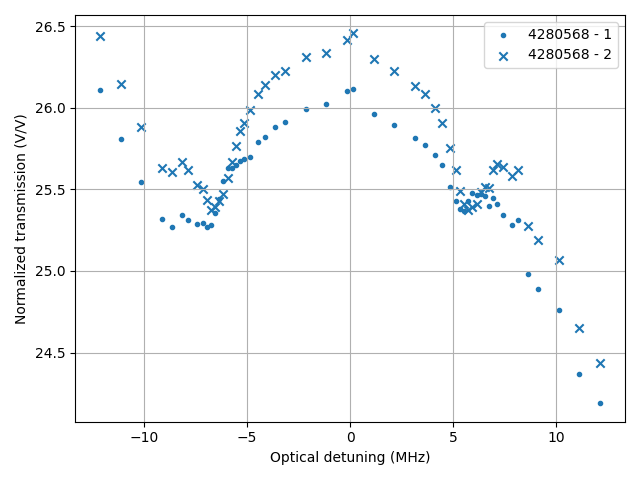

In [31]:
plot_antihole_data(4280568)

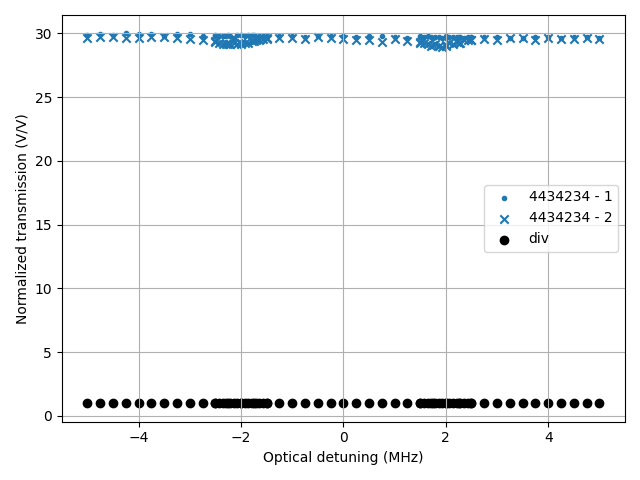

In [15]:
plot_antihole_data((4482189 + 4386279) // 2, divide_first_two = True)

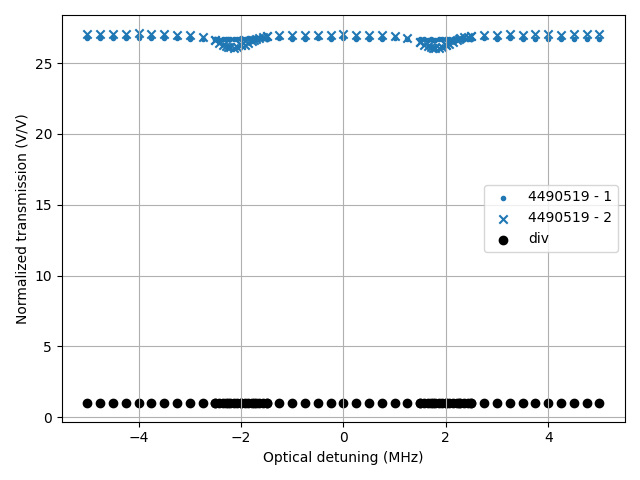

In [27]:
plot_antihole_data(4490519, divide_first_two = True) # weekend data with 200 detect amp

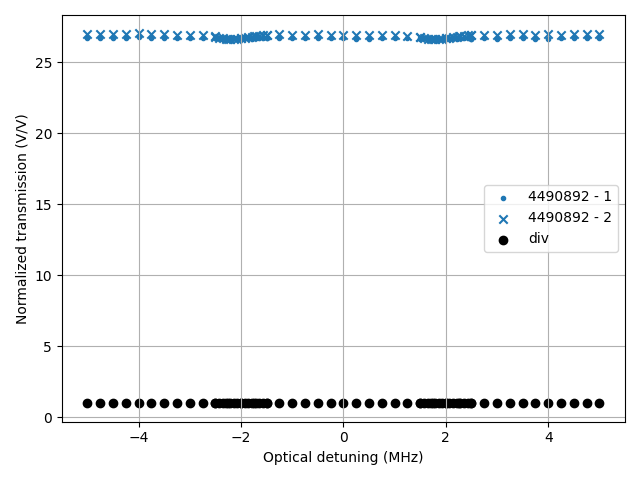

In [30]:
plot_antihole_data(4490892, divide_first_two = True) # weekend data with 200 detect amp, steady state 

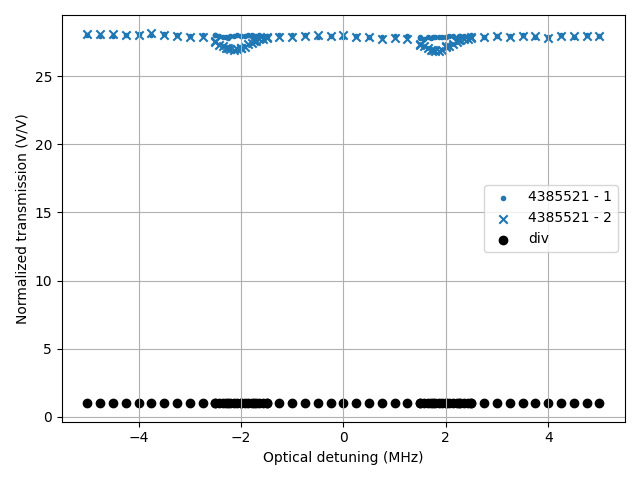

In [28]:
plot_antihole_data(4385521, divide_first_two = True)

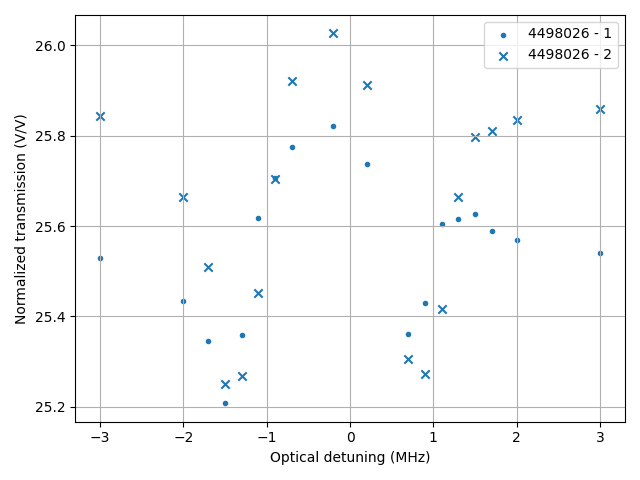

In [71]:
plot_antihole_data(4498026)

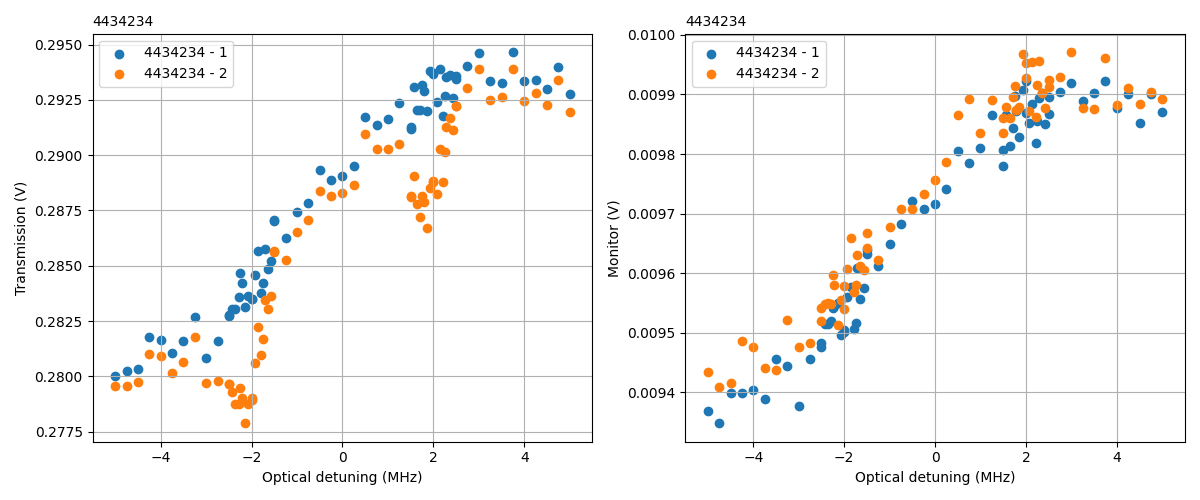

In [73]:
plot_raw_data((4482189 + 4386279) // 2)

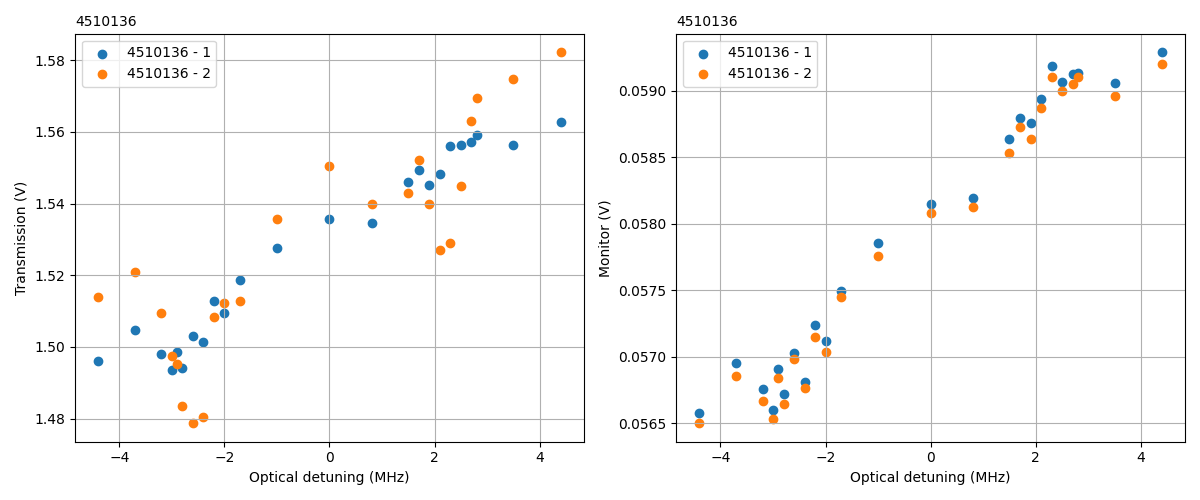

In [89]:
plot_raw_data(4510136)

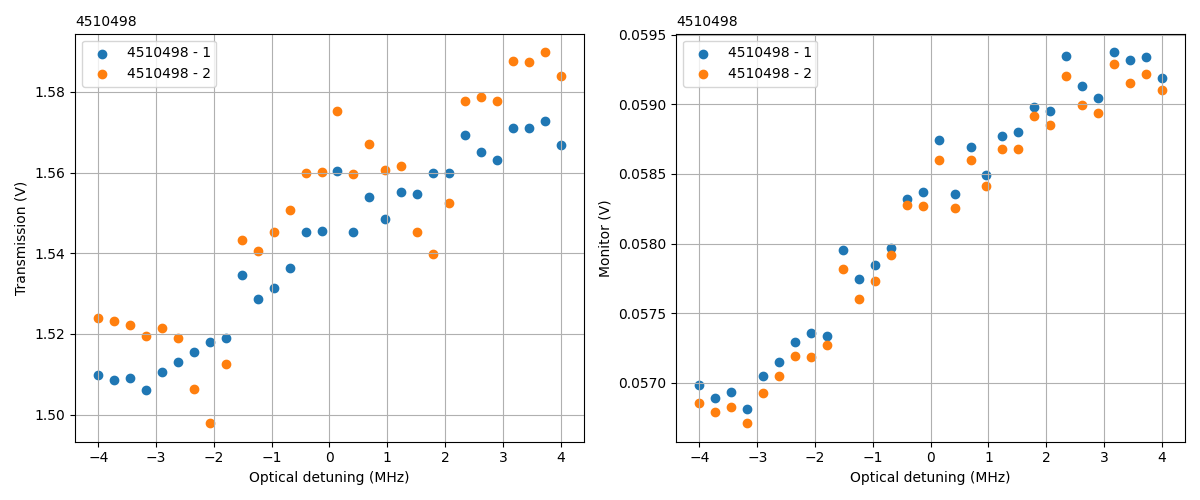

In [97]:
plot_raw_data(4510498) 

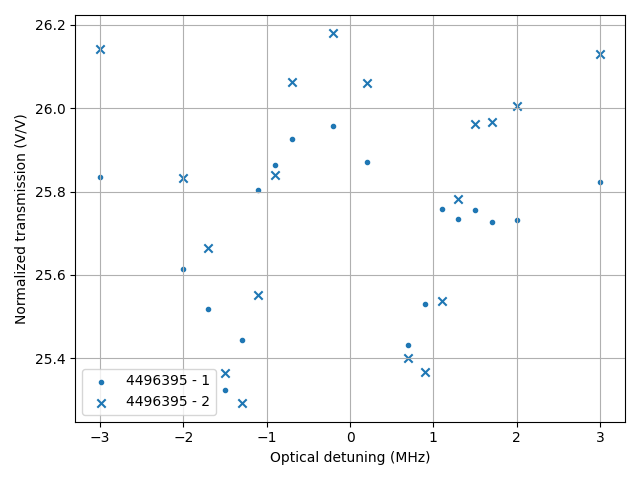

In [69]:
plot_antihole_data(4496395)

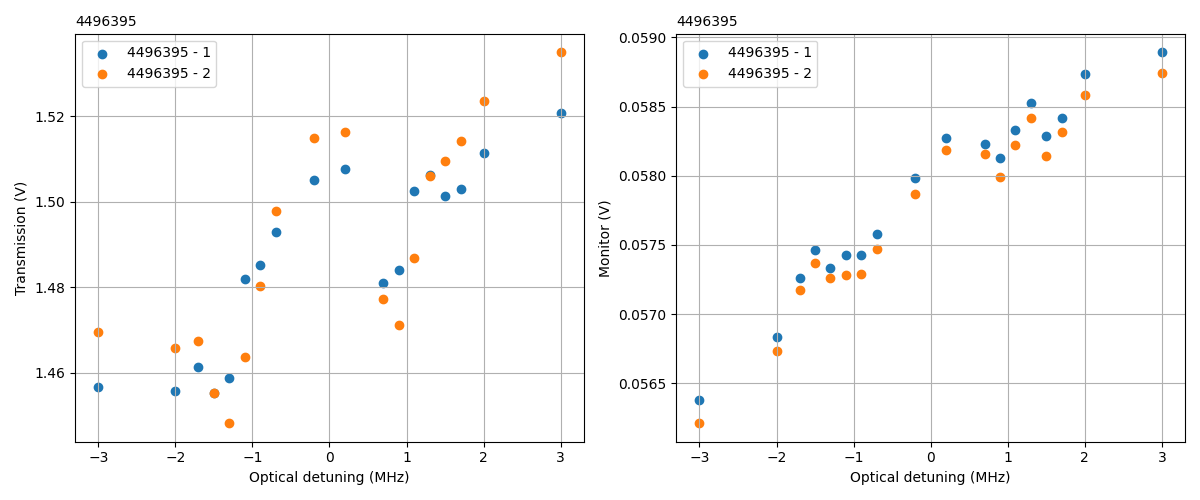

In [70]:
plot_raw_data(4496395)

In [114]:
d, h = get_experiment_data(4496091)
d, h2 = get_experiment_data(4528400)
h["params"].keys()

dict_keys(['name', 'sequence_repeats_per_transfer', 'data_transfer_repeats', 'ao', 'optical', 'chasm', 'detect', 'rf', 'lf', 'field_plate', 'digitizer', 'sequence', 'eos', 'rf_pump', 'antihole', 'cleanout', 'shutter'])

In [113]:
h["params"]["sequence"]

{'sequence': [('chasm', 0),
  ('field_plate_trigger', 1),
  ('break', 300),
  ('optical_cb', 25),
  ('optical_ac', 25),
  ('break', 200),
  ('lfpiov2', 1),
  ('detect_opposite_1', 32),
  ('rf_abarbbar', 1),
  ('lf_0', 1),
  ('rf_abarbbar', 1),
  ('detect_opposite_2', 32)]}

In [115]:
h2["params"]["sequence"]

{'sequence': [('chasm', 40),
  ('field_plate_trigger', 1),
  ('break', 300),
  ('optical_cb', 25),
  ('optical_ac', 25),
  ('break', 200),
  ('lfpiov2', 1),
  ('detect_1', 32),
  ('rf_abarbbar', 1),
  ('lf_7', 1),
  ('rf_abarbbar', 1),
  ('detect_2', 32)]}

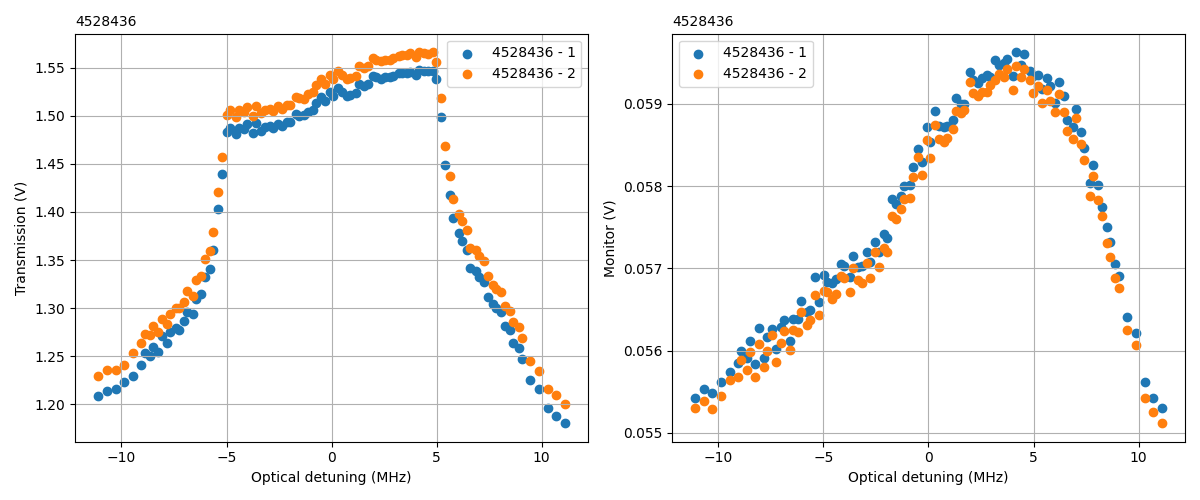

In [3]:
plot_raw_data(4528436)

In [10]:
def _flatten_dict(d, flattened_dict, current_path=[]):
    """
    Iterates through a dictionary of dictionaries and puts everythign into one dictionary.
    For example, if params["detect"]["transition"] = "ac" this function will enter "detect transition" into the flattened_dict.
    """
    if not isinstance(d, dict):
        name = " ".join(current_path)
        flattened_dict[name] = d
        return
    
    for key, value in d.items():
        new_path = current_path + [key]
        _flatten_dict(value,flattened_dict, new_path)

In [8]:
def compare_experiments(data_number1, data_number2):
    """
    Prints parameters of two experiments which are different. 
    TODO: Will falsely return parameters as different if they are lists with quantities, for example lf phase differences, and rf pump scan detunings. 
    """
    _, headers1 = get_experiment_data(data_number1)
    _, headers2 = get_experiment_data(data_number2)
    flattened1 = {}
    _flatten_dict(headers1["params"], flattened1)
    flattened2 = {}
    _flatten_dict(headers2["params"], flattened2)
    for kk in flattened1:
        if type(flattened1[kk]) == pint.Quantity:
            print("Pint Quantity")
            print(flattened1[kk])
        else:
            try:
                if flattened1[kk] == flattened2[kk]:
                    continue
                else:
                    print(f"{kk}: {flattened1[kk]} \t {flattened2[kk]}")
            except:
                try:
                    print(f"{kk}: {flattened1[kk]} \t {flattened2[kk]}")
                except:
                    continue
    keys1 = set(flattened1.keys())
    keys2 = set(flattened2.keys())
    missing1 = keys1 - keys2
    missing2 = keys2 - keys2

    if len(missing1) != 0:
        print(f"{data_number2} is missing:")
        for i in missing1:
            print("\t" + i)
    if len(missing2) != 0:
        print(f"{data_number1} is missing:")
        for i in missing2:
            print("\t" + i)

In [13]:
compare_experiments(4528436, 4528436+5)

detect detunings: [-10.0 -9.591836734693878 -9.183673469387756 -8.775510204081632 -8.36734693877551 -7.959183673469388 -7.551020408163265 -7.142857142857142 -6.73469387755102 -6.326530612244898 -5.918367346938775 -5.5102040816326525 -5.1020408163265305 -4.6938775510204085 -4.285714285714286 -3.8775510204081627 -3.4693877551020407 -3.0612244897959187 -2.6530612244897958 -2.244897959183673 -1.8367346938775508 -1.4285714285714288 -1.020408163265305 -0.612244897959183 -0.204081632653061 0.204081632653061 0.612244897959183 1.0204081632653068 1.4285714285714288 1.8367346938775508 2.2448979591836746 2.6530612244897966 3.0612244897959187 3.4693877551020407 3.8775510204081627 4.2857142857142865 4.6938775510204085 5.1020408163265305 5.510204081632654 5.918367346938776 6.326530612244898 6.73469387755102 7.142857142857142 7.551020408163264 7.95918367346939 8.367346938775512 8.775510204081634 9.183673469387756 9.591836734693878 10.0] megahertz 	 [-10.0 -9.591836734693878 -9.183673469387756 -8.77551

In [21]:
d,h = get_experiment_data(4528436)
type(h["params"]["detect"]["detunings"]) 

pint.Quantity